# Задание

Решить задачу классификации рукописных цифр на датасете mnist https://www.kaggle.com/datasets/hojjatk/mnist-dataset. Правила следующие:
- нужно представить решение в виде нейронной сети, написанной на numpy, и обученной с помощью алгоритма градиентного спуска;
- нейронная сеть должна состоять из двух линейных слоев, активаций relu и softmax, и mse лосса;
- нельзя пользоваться автоградиентом (pytorch, numpy). Градиенты должны считаться вручную по алгоритму обратного распространения ошибки, используя аналитические формулы производных;
- решение считается валидным, если оно достигает аккураси больше 50%.

## Настройки/Гиперпараметры/Импорты

In [74]:
import matplotlib.pyplot as plt # для вывода графиков/картинок
import numpy as np # для работы с матрицами

import torchvision # для работы с картинками (преобразований)
import torch # для создания модели
# import cv2

In [17]:
device_id = -1 # номер девайса
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # если номер девайса >=0 - используем GPU

# Загрузка и обработка данных

In [19]:
# преобразования над датасетом
transforms = torchvision.transforms.Compose([ # Compose объединяет несколько преобразований вместе, чтобы они выполнялись "последовательно"
    torchvision.transforms.ToTensor(), # преобразование PIL изображения (или ndarray формата (Height x Width x Channels)) в tensor (типа float со значениями в области [0.0, 1.0], если такая трансформация поддерживается (см описание ToTensor))
    torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,)) # нормализация каналов (в датасете всего один канал) к указанным среднему значению и стандартному отклонению (цифры подобраны под датасет)
])

# датасет
data_train = torchvision.datasets.MNIST(root="./data", # путь, откуда брать/куда сохранять датасет
                                        train=True, # скачиание обучающей части датасета
                                        download=True, # скачивать ли датасет, если его нет в root пути
                                        transform=transforms # функция, принимающая на вход PIL Image и преобразовывающая его
                                       )

# загрузчик данных для обучения
train_loader = torch.utils.data.DataLoader(dataset=data_train, # указание датасета для DataLoader
                                           batch_size=10, # размер батчка (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла)
                                           num_workers=5, # число используемых ядер процессора для ускорения обработки данных
                                           pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                                          )

In [21]:
data_train # данные о датасете

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [23]:
data_train[0][0] # первое "изображение" датасета после применения трансформаций

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [22]:
data_train[0][1] # класс (target) первого изображения

5

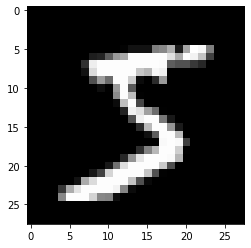

In [27]:
plt.imshow(data_train[0][0].reshape((28, 28, 1)), cmap='gray') # построение изображения
# .reshape((28, 28, 1)), так как shape(1, 28, 28) ~ (Channels, Height, Width) не воспринимается
# cmap='gray' так как изображение одноканальное, то есть чёрно-белое
plt.show() # вывод изображения

# Создание модели

$$ 
ReLU(x) =  
\left\{
\begin{array}{ll}
      0 & if & x \leq 0 \\
      x & if & x > 0 \\
\end{array} 
\right.
$$

In [ ]:
def ReLU(x: np.ndarray) -> np.ndarray: # numpy.array — это просто удобная функция для создания numpy.ndarray
    """
    Функция активации ReLU, если значение в X меньше или равно нулю - оно становится нулём, иначе — остаётся прежним.\n
    Parameters:
        * x: данные в виде массива\n
    Returns:
        * np.ndarray: преобразованный X согласно работе функции активации
    """
    x[x<0] = 0.0 # заменяем все значения в X, что меньше нуля на ноль
    return x

$$
Softmax(x_i) = \dfrac{e^{x_i}}{\sum_{j}e^{x_j}}
$$

In [86]:
def Softmax(x: np.ndarray) -> np.ndarray:
    """
    Функция Softmax, пересчитывающая для всех элементов массива x значение e^x_i/summ(e^x_i).\n
    Parameters:
        * x: данные в виде массива размерности (batch_size, class_count) ~ (размер батча, число классов)\n
    Returns:
        * np.ndarray: преобразованный X согласно формуле Softmax
    """
    e = np.exp(x) # считаем экспоненту от всех элементов X (каждый элемент в X идёт как степень e)
    for row in range(e.shape[0]): # идём по батчам
        e[row] = e[row] / e[row].sum() # каждый элемент (экспоненту) в батче делим на сумму экспонент этого батча
    return e # возвращаем результат Softmax

In [110]:
a = torch.randn(size=(1, 3))
b = torch.randn(size=(3, 3))
c = torch.randn(size=(3, 1))

In [111]:
np.matmul(a, b)

tensor([[-1.2184,  4.5657, -3.8252]])

In [112]:
np.add(np.matmul(a, b), c)

tensor([[-1.2745,  4.5096, -3.8813],
        [-1.5375,  4.2466, -4.1443],
        [-1.4556,  4.3285, -4.0624]])

In [107]:
np.matmul(b, np.transpose(a))

tensor([[ 3.8514],
        [-1.7694],
        [-3.6416]])

In [113]:
np.add(np.matmul(b, np.transpose(a)), c)

tensor([[ 2.3293],
        [-1.0998],
        [-0.4355]])

$$
y = xW^T + b
$$
* W - вектора-строка весов, поэтому для умножения её транспонируют, получая вектор-столбец
* b - вектор-столбец для смещения

In [ ]:
class Linear: # линейный слой без смещения (bias)
    def __init__(self, in_feature, out_features):
        """
        Конструктор линейного слоя.
        """
        # self.w = np.random.randn(28*28, 128)
        # self.bias = np.random.randn(128)

        self.w = np.random.randn(in_feature, out_features)
        self.bias = np.random.randn(out_features, 1) # смещение как вектор-столбец
        # self.w = np.random.randn(out_features, in_feature)
        # self.bias = np.random.randn(out_features) # смещение как вектор-строка


    def forward(self, x):
        """
        Функция, применяющая веса и смещение к входным данным.\n
        """
        res = np.matmul(x, np.transpose(self.w)) # умножаем вход на веса
        # res = np.matmul(self.w, X) # умножаем вход на веса

        # res = np.add(res, self.bias) # добавляем смещение (bias)
        return res
        
    
    def backward(self, grad):
        """
        Функция, обновляющая веса слоя и передающая градиент дальше.\n
        """
        
        return grad
    
# w = self.w + lr * grad

In [88]:
a = torch.randn(size=(10, 10))
a

tensor([[-0.9054,  0.0064,  0.4978,  2.1084,  1.0042, -0.5669, -0.2678,  0.0864,
         -0.3227,  0.4695],
        [-0.1141,  0.4753, -1.6757,  1.4173, -2.5453,  0.0331,  0.9049,  0.0460,
         -0.4210,  0.0820],
        [ 0.4094, -0.1510,  0.0327, -0.3660,  1.4307, -0.6699, -0.7729,  1.7728,
         -0.0171, -0.7013],
        [-0.7132, -0.1929, -0.9114, -0.5718, -1.4050, -0.2127, -1.6851, -0.2172,
          0.3872, -0.7675],
        [ 0.0987,  2.4038,  0.2354, -1.5270,  0.9169,  0.4375, -1.0972, -0.2811,
          0.9684,  0.2380],
        [-1.3420,  0.4732,  1.3907, -0.4560, -0.9936,  1.0010, -0.2646, -1.9361,
         -0.5648,  1.4722],
        [-0.8058, -0.2843, -1.9999,  0.1460,  0.9025,  0.6061,  3.1371,  1.3992,
         -0.9869, -0.1091],
        [-0.3603,  1.1424,  1.5008,  1.4834, -0.5067,  0.9092, -0.3268, -0.6520,
          0.5621, -0.1392],
        [ 1.1130, -1.7527,  1.4093, -0.5442,  0.4997,  0.1407,  0.2418,  0.2057,
          0.3699, -0.4253],
        [ 0.2794, -

In [ ]:
class CustomNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(28*28, 128)
        self.linear2 = Linear(128, 10)
        self.activation = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1) # dim - измерение, по которому будет вычисляться Softmax

    def forward(self, X):
        X = torch.flatten(X, 1)
        X = self.linear1(X)
        X = self.linear2(X)
        X = self.activation(X)
        X = self.softmax(X)
        return X

# Обучение модели

In [ ]:
def train(model, train_loader, optimizer): # функция обучения
    model.train() # перевод модель в режим обучения ~ включает Dropout, BatchNorm... (изначально модель уже в состоянии train, а не eval)
    for batch_idx, (data, target) in enumerate(train_loader): # идём по батчам, что возвращает train_loader
        data, target = data.to(device), target.to(device) # отправляем данные на девайс
        optimizer.zero_grad() # обнуляем градиенты во всех обучаемых torch.Tensor (ставит w.grad = 0 в torch.Tensor с requires_grad=True) (вызывается перед loss.backward(), чтобы не аккумулировать градиенты за несколько итераций обучения)
        output = model(data) # вызываем forward pass модели (предсказываем)
        loss = F.nll_loss(output, target) # считаем loss модели
        loss.backward() # считаем dloss/dw для каждого веса модели w, у которого requires_grad=True (сохраняется в w.grad следующим образом w.grad += dloss/dw)
        optimizer.step() # обновляет веса модели (тензоры, у которых стоит флаг requires_grad=True, используя значение из w.grad следующим образом w += -lr * w.grad)

In [ ]:
model = CustomNetwork()
optimizer = optim.Adadelta(model.parameters(), lr=0.01) # оптимайзер для обновления весов модели
sheduler = StepLR(optimizer, step_size=1, gamma=0.9) # шедулер для динамического изменения lr

criterion = torch.nn.CrossEntropyLoss() # loss - кросс-энтропия (перекрёстная энтропия)
# CrossEntropyLoss на вход ожидает вероятность класса для всех k классов
# то есть массив с вероятностями для каждой из четырёх категорий новостей

In [ ]:
state_dict = model.state_dict()
state_dict.keys()

In [ ]:
state_dict[]

In [ ]:
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
sheduler = StepLR(optimizer, step_size=1, gamma=0.9)

In [ ]:
criterion = nn.BCELoss() # определяем функцию потерь — бинарную кросс-энтропию (хорошо для задачи бинарной классификации, где таргет может принимать лишь два значения - 0 и 1)
# При бинарной классификации каждая предсказанная вероятность сравнивается с фактическим значением класса (0 или 1), 
# и вычисляется оценка, которая штрафует вероятность на основе расстояния от ожидаемого значения.

# BCELoss выше, чем MSEloss примерно раза в 4 (на выбранном датасете), поэтому значение в 0.4 для BCE — это хорошо
model_log = LogisticRegression(X_train.shape[1], Y_train.shape[1]).to(torch.float64) # создаём объект модели

optimizer_1 = optim.Adam(model_log.parameters(), lr=learning_rate) # определяем оптимайзер — Adam и передаём в него веса модели с lr

for epoch in range(num_epochs): # проводим обучение и тестирование num_epochs раз
    Y_pred = model_log(X_train) # делаем предсказание
    loss = criterion(Y_pred, Y_train) # считаем ошибку по BCE loss

    losses["LogisticRegression"]["train"].append(loss.data) # запоминаем значение BCEloss

    optimizer_1.zero_grad() # обнуляем градиенты во всех обучаемых torch.Tensor (ставит w.grad = 0 в torch.Tensor с requires_grad=True) (вызывается перед loss.backward(), чтобы не аккумулировать градиенты за несколько итераций обучения)
    loss.backward() # считаем dloss/dw для каждого веса модели w, у которого requires_grad=True (сохраняется в w.grad следующим образом w.grad += dloss/dw)
    optimizer_1.step() # обновляет веса модели (тензоры, у которых стоит флаг requires_grad=True, используя значение из w.grad следующим образом w += -lr * w.grad)

    with torch.no_grad(): # запускаем валидацию (каждую эпоху)
        Y_pred = model_log(X_test) # вызываем forward с передачей X_test
        losses["LogisticRegression"]["test"].append(criterion(Y_pred, Y_test).data) # запоминаем значение BCEloss
plt.figure(figsize=(10,8)) # задание размера графика
plt.plot(losses["LogisticRegression"]["train"], "b", label='train') # построение BCE loss на обучении
plt.plot(losses["LogisticRegression"]["test"], "r", label='test') # построение BCE loss на тестировании

plt.title('BCE Loss with LogisticRegression') # название графика
plt.xlabel('epoch') # подпись по оси x
plt.ylabel('loss') # подпись по оси y
plt.legend() # вывод названий графиков
plt.show() # вывод графика

Всякие тесты

In [117]:
linear = torch.nn.Linear(10,100,bias = True)
linear.weight.shape

torch.Size([100, 10])